In [1]:
import sys
sys.path.append('../src')  # so we can import from src

from data_prep import load_and_clean_data, preprocess_data

# Load and clean raw data
df = load_and_clean_data('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preprocess to get X and y
X, y = preprocess_data(df)

# Preview shapes
print("Features shape:", X.shape)
print("Target shape:", y.shape)

# See first few processed rows
X.head()


Features shape: (7032, 19)
Target shape: (7032,)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,0,0,1,0,-1.280248,0,1,0,0,2,0,0,0,0,0,1,2,-1.161694,-0.994194
1,1,0,0,0,0.064303,1,0,0,2,0,2,0,0,0,1,0,3,-0.260878,-0.173740
2,1,0,0,0,-1.239504,1,0,0,2,2,0,0,0,0,0,1,3,-0.363923,-0.959649
3,1,0,0,0,0.512486,0,1,0,2,0,2,2,0,0,1,0,0,-0.747850,-0.195248
4,0,0,0,0,-1.239504,1,0,1,0,0,0,0,0,0,0,1,2,0.196178,-0.940457


This notebook will:

Split your data into train/test sets

Train multiple models

Evaluate them with accuracy, precision, recall, F1, ROC-AUC

Help you decide which model performs best

In [2]:
from data_prep import load_and_clean_data, preprocess_data
from sklearn.model_selection import train_test_split

# Load and preprocess the data
df = load_and_clean_data('../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv')
X, y = preprocess_data(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (5625, 19)
Test shape: (1407, 19)


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Support Vector Machine": SVC(probability=True)
}

# Store results
results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]  # for ROC-AUC

    # Evaluation metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)

    # Save results
    results[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "ROC AUC": roc
    }

    print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}, ROC AUC: {roc:.2f}")



Training Logistic Regression...
Accuracy: 0.79, Precision: 0.62, Recall: 0.49, F1: 0.55, ROC AUC: 0.83

Training Random Forest...
Accuracy: 0.79, Precision: 0.65, Recall: 0.48, F1: 0.55, ROC AUC: 0.82

Training Support Vector Machine...
Accuracy: 0.79, Precision: 0.67, Recall: 0.46, F1: 0.54, ROC AUC: 0.78


In [4]:
import pandas as pd

# Display results in table form
results_df = pd.DataFrame(results).T  # transpose
results_df = results_df.sort_values(by="ROC AUC", ascending=False)
results_df


,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.786070,0.622896,0.494652,0.551416,0.830735
Random Forest,0.792466,0.648551,0.478610,0.550769,0.815723
Support Vector Machine,0.794598,0.665370,0.457219,0.541997,0.783505


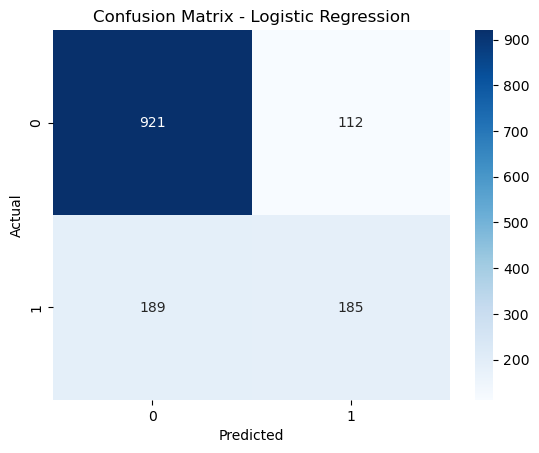

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pick best model (Random Forest is usually strongest here)
best_model = models["Logistic Regression"]
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


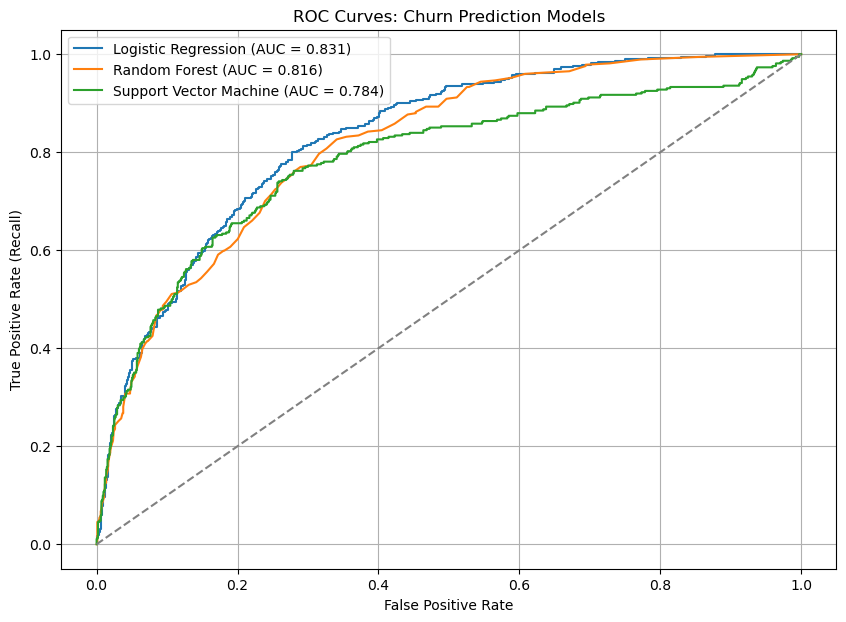

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

# Set plot style
plt.figure(figsize=(10, 7))

# Loop through each model and plot its ROC curve
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

# Plot random guess baseline
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Add labels and legend
plt.title("ROC Curves: Churn Prediction Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.legend()
plt.grid(True)
plt.show()


In [10]:
# Try a lower threshold
threshold = 0.35  # instead of 0.5

# New predictions based on adjusted threshold
y_pred_custom = (y_proba >= threshold).astype(int)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_custom))


              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1033
           1       0.54      0.71      0.61       374

    accuracy                           0.76      1407
   macro avg       0.71      0.74      0.72      1407
weighted avg       0.79      0.76      0.77      1407

